In [ ]:
import numpy as np
import matplotlib.pyplot as plt

RANGE = 5
SAMPLES = 11
ALPHA_TIME = 1 # total_time = SUM(ALPHA_TIME * dist_{i,i+1})
SEED = 28

Genero una serie de puntos aleatorios

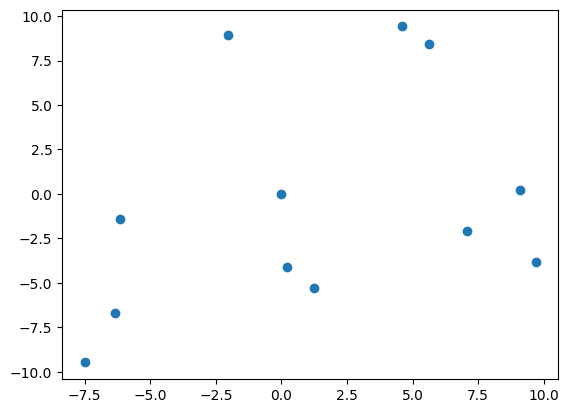

In [ ]:
np.random.seed(SEED)
xs = np.concatenate([[0], np.random.uniform(-RANGE, RANGE, SAMPLES)])
ys = np.concatenate([[0], np.random.uniform(-RANGE, RANGE, SAMPLES)])
plt.scatter(xs, ys)

Calculo la secuencia mas corta para recorrerlos

Vease https://developers.google.com/optimization/routing/tsp

In [ ]:
def create_data_model(x, y):
    """Stores the data for the problem."""
    data = {}
    data["locations"] = list(zip(x, y))
    data["distance_matrix"] = np.zeros((len(data["locations"]), len(data["locations"])))
    for i in range(len(data["locations"])):
        for j in range(len(data["locations"])):
            data["distance_matrix"][i][j] = np.linalg.norm(np.array(data["locations"][i]) - np.array(data["locations"][j]))
    data["num_vehicles"] = 1
    data["depot"] = 0
    return data

In [ ]:
from ortools.constraint_solver import pywrapcp, routing_enums_pb2

data = create_data_model(xs, ys)
manager = pywrapcp.RoutingIndexManager(
    len(data["distance_matrix"]), data["num_vehicles"], data["depot"]
)
routing = pywrapcp.RoutingModel(manager)

In [ ]:
def distance_callback(from_index, to_index, manager=manager, data=data):
    """Returns the distance between the two nodes."""
    # Convert from routing variable Index to distance matrix NodeIndex.
    from_node = manager.IndexToNode(from_index)
    to_node = manager.IndexToNode(to_index)
    return int(data["distance_matrix"][from_node][to_node])

transit_callback_index = routing.RegisterTransitCallback(distance_callback)

# Funcion objetivo
routing.SetArcCostEvaluatorOfAllVehicles(transit_callback_index)

In [ ]:
search_parameters = pywrapcp.DefaultRoutingSearchParameters()
search_parameters.first_solution_strategy = (
    routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC
)
search_parameters.local_search_metaheuristic = (
    routing_enums_pb2.LocalSearchMetaheuristic.GUIDED_LOCAL_SEARCH
)
search_parameters.time_limit.FromMilliseconds(1000)

# Solve the problem.
solution = routing.SolveWithParameters(search_parameters)

In [ ]:
def print_solution(manager, routing, solution):
    """Prints solution on console."""
    print(f"Objective: {solution.ObjectiveValue()}")
    index = routing.Start(0)
    plan_output = "Route for vehicle 0:\n"
    route_distance = 0
    while not routing.IsEnd(index):
        plan_output += f" {manager.IndexToNode(index)} ->"
        previous_index = index
        index = solution.Value(routing.NextVar(index))
        route_distance += routing.GetArcCostForVehicle(previous_index, index, 0)
    plan_output += f" {manager.IndexToNode(index)}\n"
    plan_output += f"Route distance: {route_distance/1000}\n"
    print(plan_output)

In [ ]:
solution = routing.SolveWithParameters(search_parameters)
if solution:
    print_solution(manager, routing, solution)

Objective: 61
Route for vehicle 0:
 0 -> 11 -> 7 -> 3 -> 6 -> 2 -> 8 -> 10 -> 9 -> 5 -> 1 -> 4 -> 0
Route distance: 0.061



In [ ]:
def get_routes(solution, routing, manager):
    """Get vehicle routes from a solution and store them in an array."""
    # Get vehicle routes and store them in a two dimensional array whose
    # i,j entry is the jth location visited by vehicle i along its route.
    routes = []
    time = [0]
    for route_nbr in range(routing.vehicles()):
        index = routing.Start(route_nbr)
        location_index = manager.IndexToNode(index)
        route = [data["locations"][location_index]]
        while not routing.IsEnd(index):
            previous_index = index
            index = solution.Value(routing.NextVar(index))
            location_index = manager.IndexToNode(index)
            route.append(data["locations"][location_index])
            time.append(time[-1] + ALPHA_TIME * data['distance_matrix'][previous_index][location_index])
        routes.append(route)
    return np.array(routes[0]), np.array(time)

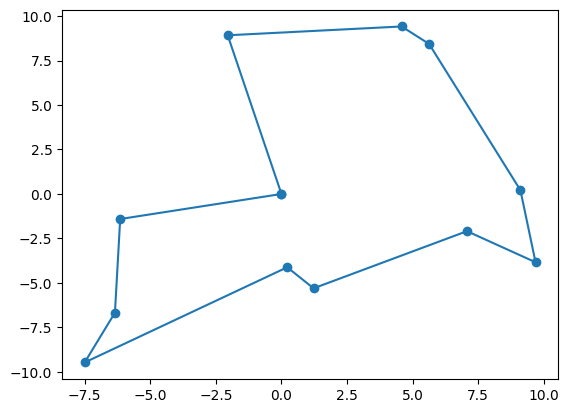

In [ ]:
data['locations_sorted'], data['time_sorted'] = get_routes(solution, routing, manager)

plt.plot(data['locations_sorted'][:, 0], data['locations_sorted'][:, 1], marker='o')

### Splines
Genero una curva spline que pase por esos puntos en ese orden

#### Recorrido exacto (CubicSpline)

In [ ]:
from scipy.interpolate import CubicSpline

# Create separate splines for x and y coordinates
cs_x = CubicSpline(data['time_sorted'], data['locations_sorted'][:, 0], bc_type='natural') # f(x(t))
cs_y = CubicSpline(data['time_sorted'], data['locations_sorted'][:, 1], bc_type='natural') # f(y(t))

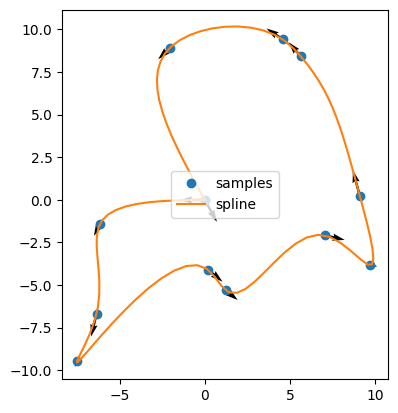

In [ ]:
ts_new = np.linspace(0, max(data['time_sorted']), 100)

fig, ax = plt.subplots()
ax.plot(data['locations_sorted'][:, 0], data['locations_sorted'][:, 1], 'o', label='samples')
ax.plot(cs_x(ts_new), cs_y(ts_new), label='spline')
ax.axes.set_aspect('equal')
ax.legend(loc='center')

# Derivadas
dxdt = cs_x.derivative()(data['time_sorted'])
dydt = cs_y.derivative()(data['time_sorted'])
ax.quiver(data['locations_sorted'][:, 0], data['locations_sorted'][:, 1], dxdt, dydt)
plt.show()

In [ ]:
# calculo los angulos
angles = np.arctan2(dydt, dxdt)
angles

array([-3.12772842, -2.04016436, -1.8047605 , -1.92516202, -0.6919978 ,
       -0.68377972, -0.22272782, -0.13583185,  1.83536643,  2.28153479,
        2.54639644, -2.36570021, -1.06514456])

In [ ]:
data['spline_waypoints'] = np.concatenate((data['time_sorted'][:, None], data['locations_sorted'], angles[:, None]), axis=1)
print(data['spline_waypoints'])
data['spline_waypoints'] = data['spline_waypoints'].reshape(-1).round(8).tolist() # Listo para copiar y pegar en el launch

[[ 0.          0.          0.         -3.12772842]
 [ 6.30533871 -6.14598052 -1.40862333 -2.04016436]
 [11.57504377 -6.34613283 -6.67452596 -1.8047605 ]
 [14.60224626 -7.50065816 -9.47292303 -1.92516202]
 [23.99665905  0.21985963 -4.12048464 -0.6919978 ]
 [25.54914167  1.22479205 -5.30383291 -0.68377972]
 [32.21909456  7.0702575  -2.0915432  -0.22272782]
 [35.36354301  9.68426937 -3.83925543 -0.13583185]
 [39.45703878  9.10743785  0.2133947   1.83536643]
 [48.38484873  5.62616413  8.43449704  2.28153479]
 [49.81908725  4.58027485  9.41590203  2.54639644]
 [56.46594922 -2.04815263  8.92120686 -2.36570021]
 [65.61924704  0.          0.         -1.06514456]]


##### Recorrido aproximado (splprep, splev)
Parametro s: smooth factor

In [ ]:
from scipy.interpolate import splprep, splev
tck, u = splprep(data['locations_sorted'].T, s=1)
x_i,y_i= splev(np.linspace(0, 1, 100),tck)

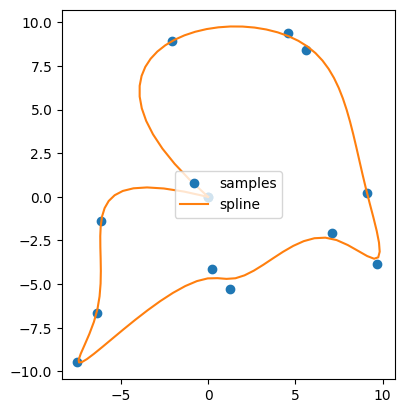

In [ ]:
fig, ax = plt.subplots()
ax.plot(data['locations_sorted'][:, 0], data['locations_sorted'][:, 1], 'o', label='samples')
ax.plot(x_i, y_i, label='spline')
ax.axes.set_aspect('equal')
ax.legend(loc='center')
plt.show()

In [ ]:
# Idem derivadas y angulos para este caso
u_new = np.linspace(0, 1, len(u))
x_aprox, y_aprox = splev(u_new, tck)
dxdu, dydu = splev(u_new, tck, der=1)
angles_aprox = np.arctan2(dydu, dxdu)
param_aprox = np.linspace(0, max(data['time_sorted']), len(u_new))

waypoints_aprox = np.column_stack((param_aprox, x_aprox, y_aprox, angles_aprox))
print(waypoints_aprox)
data["spline_waypoints_aprox"] = waypoints_aprox.reshape(-1).round(8).tolist()

[[ 0.00000000e+00 -3.01070126e-03 -2.21121916e-03  2.89950296e+00]
 [ 5.46827059e+00 -5.97450845e+00 -7.57940531e-01 -1.91620436e+00]
 [ 1.09365412e+01 -6.27162317e+00 -6.06597804e+00 -1.73391736e+00]
 [ 1.64048118e+01 -7.02614536e+00 -9.35203745e+00  5.79300010e-01]
 [ 2.18730823e+01 -2.01632202e+00 -5.50339770e+00  5.44830005e-01]
 [ 2.73413529e+01  2.75384438e+00 -4.14995960e+00  5.39890168e-01]
 [ 3.28096235e+01  7.68137545e+00 -2.60542569e+00 -4.22532147e-01]
 [ 3.82778941e+01  9.52117095e+00 -1.38076121e+00  1.81950620e+00]
 [ 4.37461647e+01  7.93538782e+00  4.99077417e+00  1.86816940e+00]
 [ 4.92144353e+01  5.03358571e+00  9.01076451e+00  2.67296328e+00]
 [ 5.46827059e+01 -4.18247240e-01  9.54164285e+00 -2.91033464e+00]
 [ 6.01509765e+01 -3.90542155e+00  6.50869821e+00 -1.71520321e+00]
 [ 6.56192470e+01 -1.38054660e-03 -1.84905058e-03 -7.18117425e-01]]
